[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 2s 2s/step


C:\Users\cyrus\AppData\Local\Temp\ipykernel_19668\572064452.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<AxesSubplot:title={'center':'JPY=X'}, xlabel='Date'>

<Figure size 2500x1500 with 0 Axes>

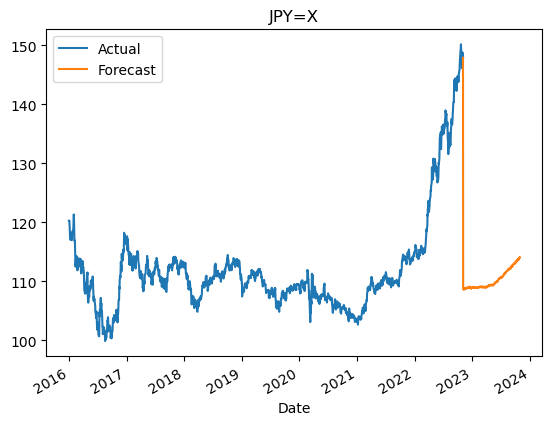

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = yf.download(tickers=['JPY=X'], start='2016-01-01', end='2022-11-04')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 360  # length of input sequences (lookback period)
n_forecast = 360  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=360 , return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=180, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units=90, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units=30))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

import matplotlib.pyplot as plt

results = df_past.append(df_future).set_index('Date')
plt.figure(figsize=(25, 15))
# plot the results
results.plot(title='JPY=X')
